In [56]:
import pandas as pd
import numpy as np
import warnings
from pandas.io.json import json_normalize
import seaborn
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
# https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
def load_df(csv_path='../data/train.csv'):

    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

In [3]:
%%time
train = load_df("../data/train.csv")
test = load_df("../data/test.csv")

CPU times: user 5min 31s, sys: 24.6 s, total: 5min 55s
Wall time: 2h 43min 35s


In [4]:
cols_to_drop = [col for col in train.columns if train[col].nunique() == 1]

In [6]:
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop([col for col in cols_to_drop if col in test.columns], axis=1, inplace=True)
print(f'Dropped {len(cols_to_drop)} columns.')

Dropped 24 columns.


In [7]:
train.tail()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
903648,Social,20170104,5123779100307500332,5123779100307500332_1483554750,1483554750,1,1483554750,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/yt/about/,youtube.com
903649,Social,20170104,7231728964973959842,7231728964973959842_1483543798,1483543798,1,1483543798,Chrome,mobile,True,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/yt/about/,youtube.com
903650,Social,20170104,5744576632396406899,5744576632396406899_1483526434,1483526434,1,1483526434,Android Webview,mobile,True,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/yt/about/ko/,youtube.com
903651,Social,20170104,2709355455991750775,2709355455991750775_1483592857,1483592857,1,1483592864,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/l.php,facebook.com
903652,Social,20170104,0814900163617805053,0814900163617805053_1483574474,1483574474,1,1483574474,Chrome,mobile,True,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/yt/about/es-419/,youtube.com


In [10]:
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')
gdf = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

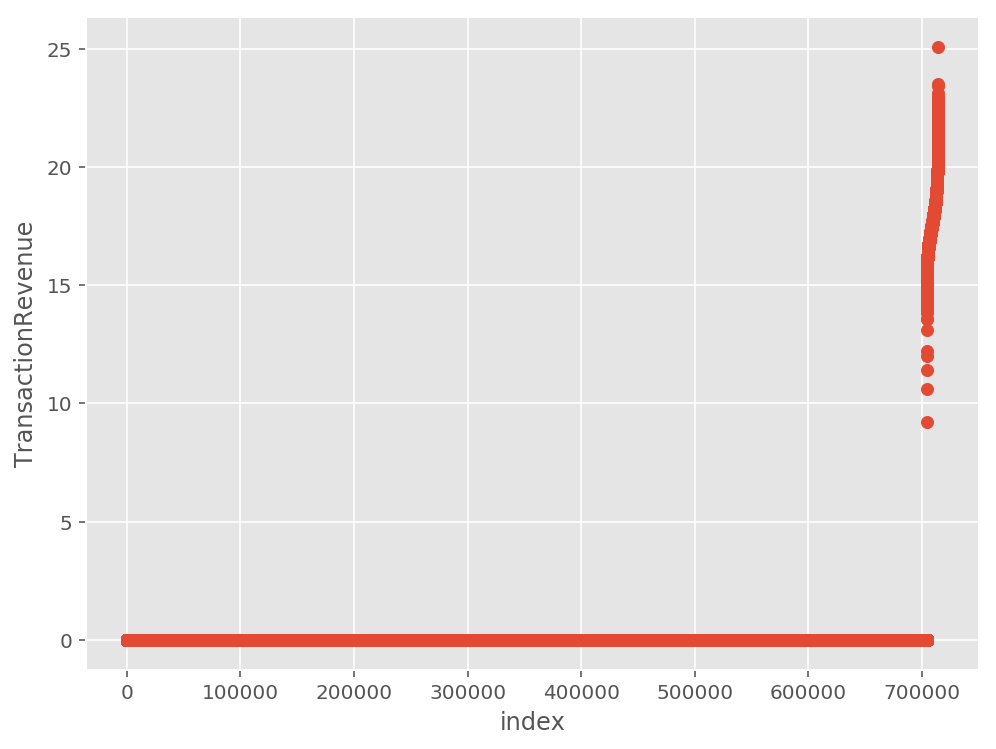

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [34]:
nzi = pd.notnull(train["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("="*65)
print("Number of instances in train set with non-zero revenue :", nzi, "\nTotal number of instance is :", train.shape[0], "\nand ratio is :", nzi / train.shape[0])
print("="*65)
print("Number of unique customers with non-zero revenue :", nzr, "\nTotal number of unique customers is :", gdf.shape[0], "\nand the ratio is :", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue : 11515 
Total number of instance is : 903653 
and ratio is : 0.0127427231470487
Number of unique customers with non-zero revenue : 9996 
Total number of unique customers is : 714167 
and the ratio is : 0.013996726255903731


- 1.3%의 고객이 수익을 창출

In [41]:
print("Number of unique visitors in train set :",train.fullVisitorId.nunique(), " out of rows :",train.shape[0])
print("Number of unique visitors in test set :",test.fullVisitorId.nunique(), " out of rows :", test.shape[0])
print("Number of common visitors in train and test set :",len(set(train.fullVisitorId.unique()).intersection(set(test.fullVisitorId.unique())) ))

Number of unique visitors in train set : 714167  out of rows : 903653
Number of unique visitors in test set : 617242  out of rows : 804684
Number of common visitors in train and test set : 7679


### Plotly

In [46]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [47]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train['date'] = train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [48]:
test['date'] = test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = test.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [49]:
# Continent
cnt_srs = train.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [50]:
# Continent
cnt_srs = train.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [51]:
# Page views
cnt_srs = train.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



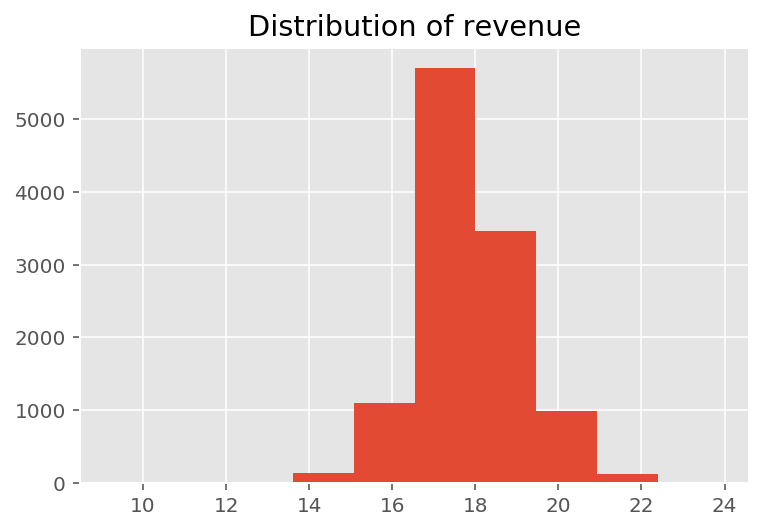

In [52]:
plt.hist(np.log1p(train.loc[train['totals.transactionRevenue'].isna() == False, 'totals.transactionRevenue']));
plt.title('Distribution of revenue');

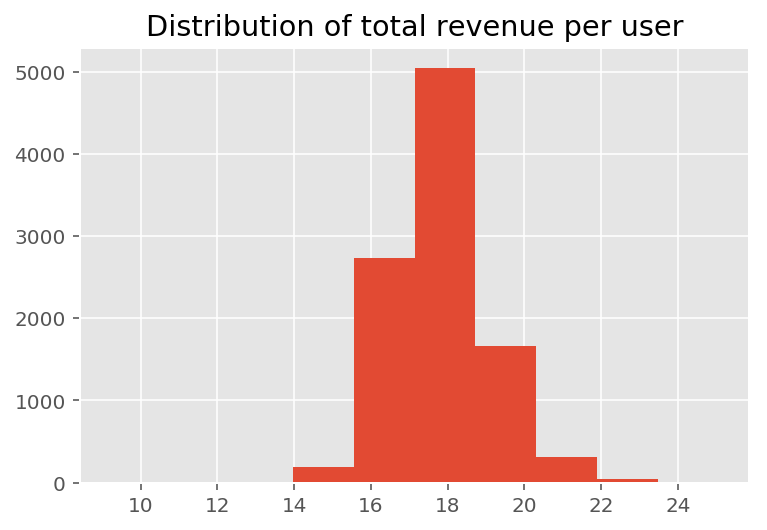

In [53]:
grouped = train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
grouped = grouped.loc[grouped['totals.transactionRevenue'].isna() == False]
plt.hist(np.log(grouped.loc[grouped['totals.transactionRevenue'] > 0, 'totals.transactionRevenue']));
plt.title('Distribution of total revenue per user');

In [54]:
counts = train.loc[train['totals.transactionRevenue'] > 0, 'fullVisitorId'].value_counts()
print('There are {0} paying users ({1} total) in train data.'.format(len(counts), train['fullVisitorId'].nunique()))
print('{0} users ({1:.4f}% of paying) have 1 paid transaction.'.format(np.sum(counts == 1), 100 * np.sum(counts == 1) / len(counts)))
print('{0} users ({1:.4f}% of paying) have 2 paid transaction.'.format(np.sum(counts == 2), 100 * np.sum(counts == 2) / len(counts)))
print('')
print('Count of non-zero transactions per user:')
counts.head(5)

There are 9996 paying users (714167 total) in train data.
9029 users (90.3261% of paying) have 1 paid transaction.
714 users (7.1429% of paying) have 2 paid transaction.

Count of non-zero transactions per user:


7813149961404844386    33
4984366501121503466    16
1957458976293878100    16
6760732402251466726    15
2402527199731150932    15
Name: fullVisitorId, dtype: int64

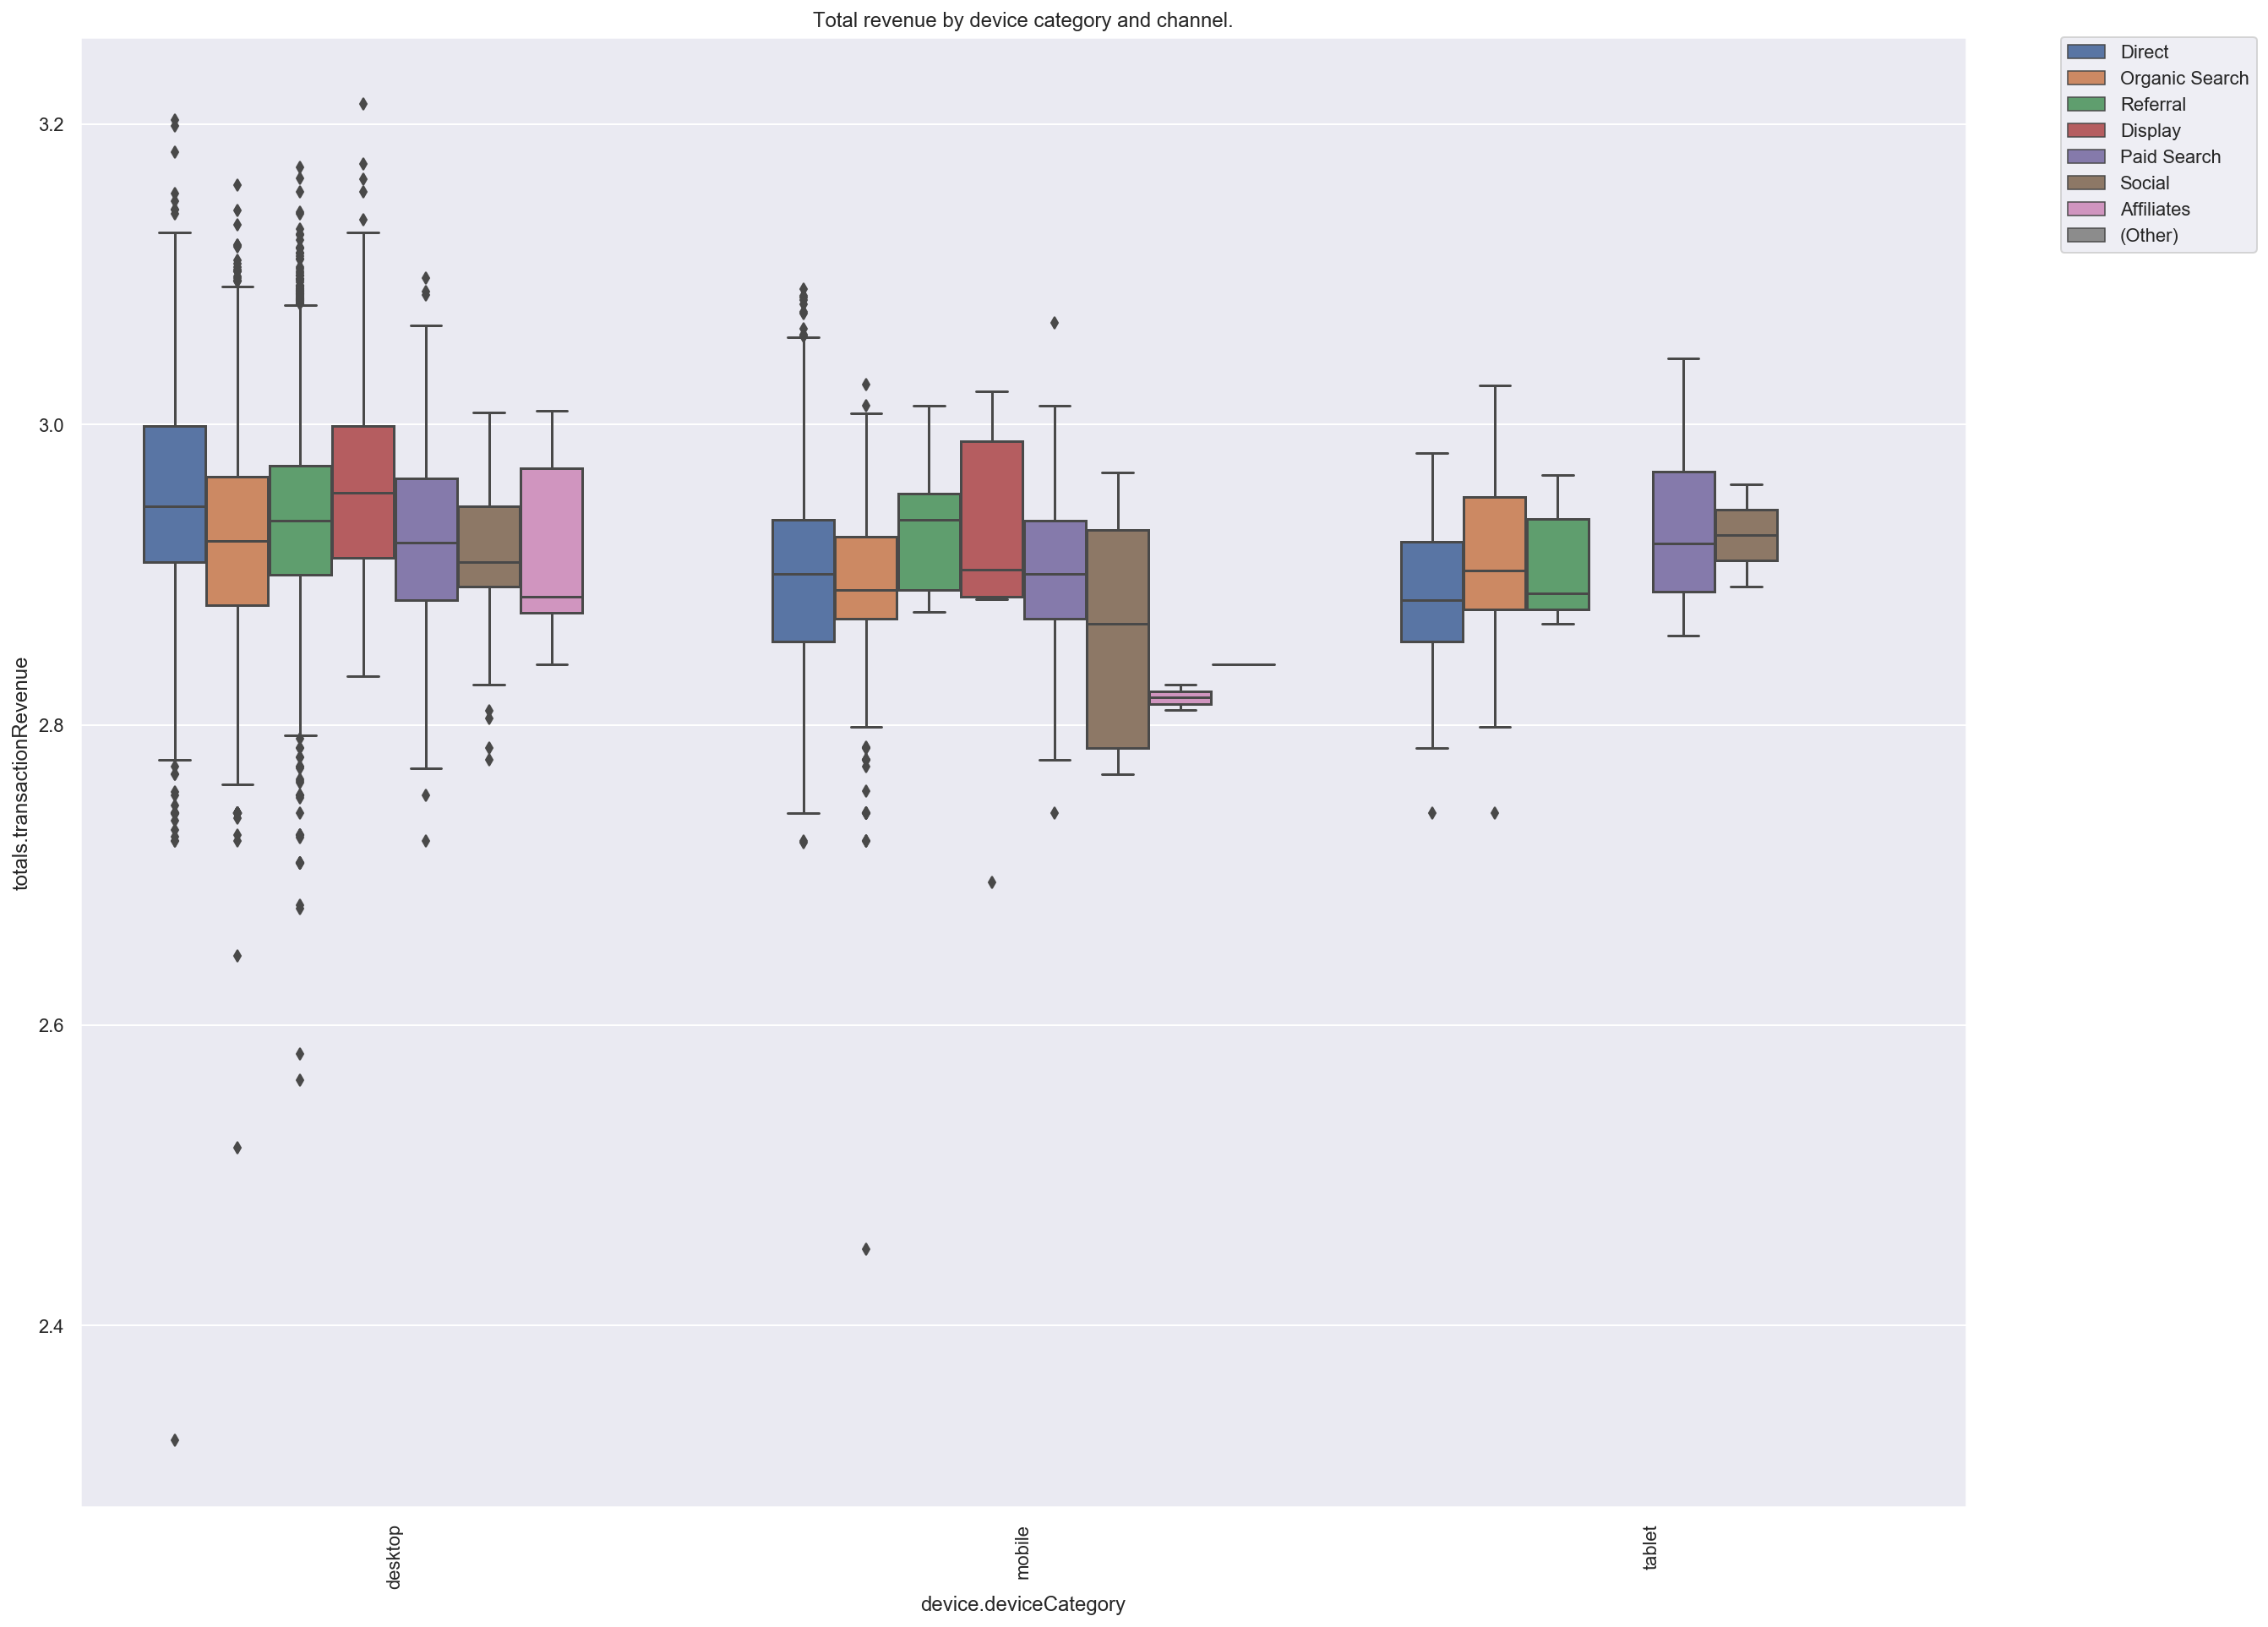

In [57]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0)
train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'])
sns.set(rc={'figure.figsize':(20, 16)})
train_ = train.loc[train['totals.transactionRevenue'] > 0.0]
sns.boxplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping",  data=train_)
plt.title("Total revenue by device category and channel.");
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

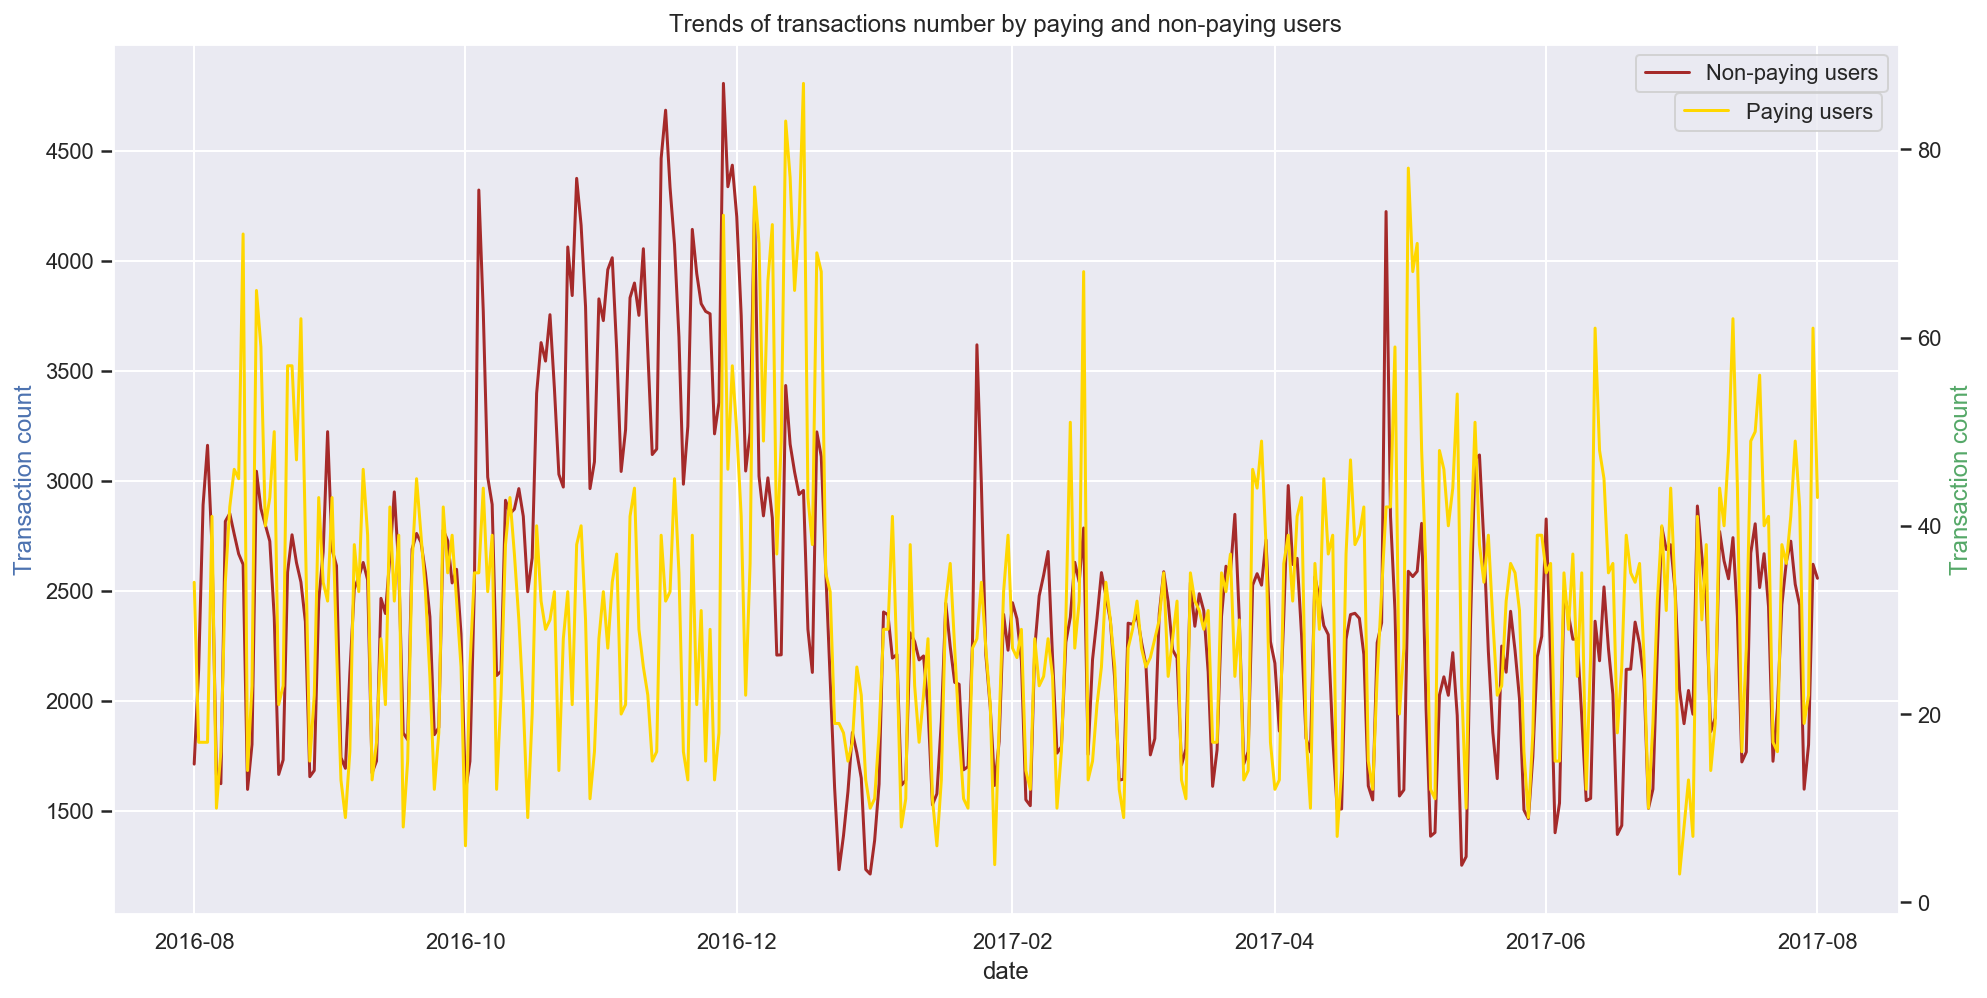

In [58]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of transactions number by paying and non-paying users");
train.groupby(['date'])['totals.transactionRevenue'].count().plot(color='brown')
ax1.set_ylabel('Transaction count', color='b')
plt.legend(['Non-paying users'])
ax2 = ax1.twinx()
train_.groupby(['date'])['totals.transactionRevenue'].count().plot(color='gold')
ax2.set_ylabel('Transaction count', color='g')
plt.legend(['Paying users'], loc=(0.875, 0.9))
plt.grid(False)

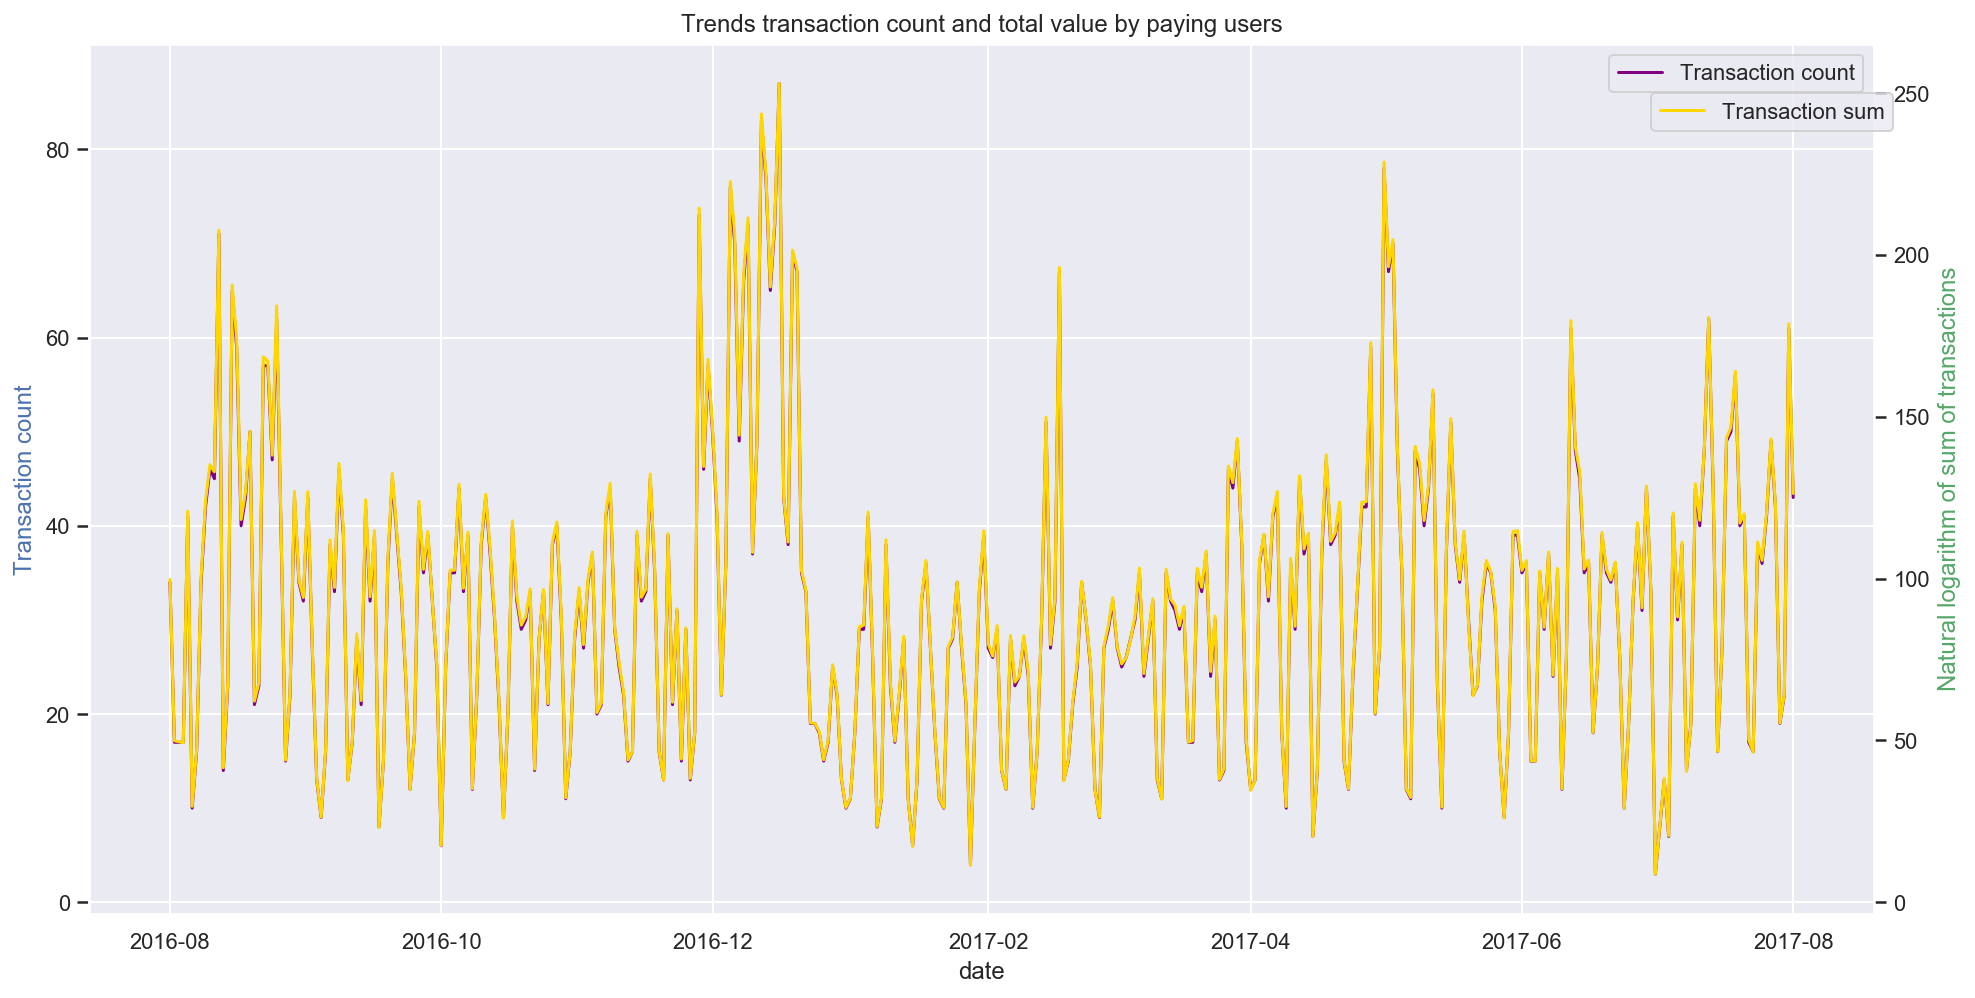

In [59]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends transaction count and total value by paying users")
train_.groupby(['date'])['totals.transactionRevenue'].count().plot(color='purple')
ax1.set_ylabel('Transaction count', color='b')
plt.legend(['Transaction count'])
ax2 = ax1.twinx()
train_.groupby(['date'])['totals.transactionRevenue'].sum().plot(color='gold')
ax2.set_ylabel('Natural logarithm of sum of transactions', color='g')
plt.legend(['Transaction sum'], loc=(0.875, 0.9))
plt.grid(False)


In [60]:
print(f'First date in train set is {train["date"].min()}. Last date in train set is {train["date"].max()}.')
print(f'First date in test set is {test["date"].min()}. Last date in test set is {test["date"].max()}.')


First date in train set is 2016-08-01. Last date in train set is 2017-08-01.
First date in test set is 2017-08-02. Last date in test set is 2018-04-30.


Mean revenue per transaction


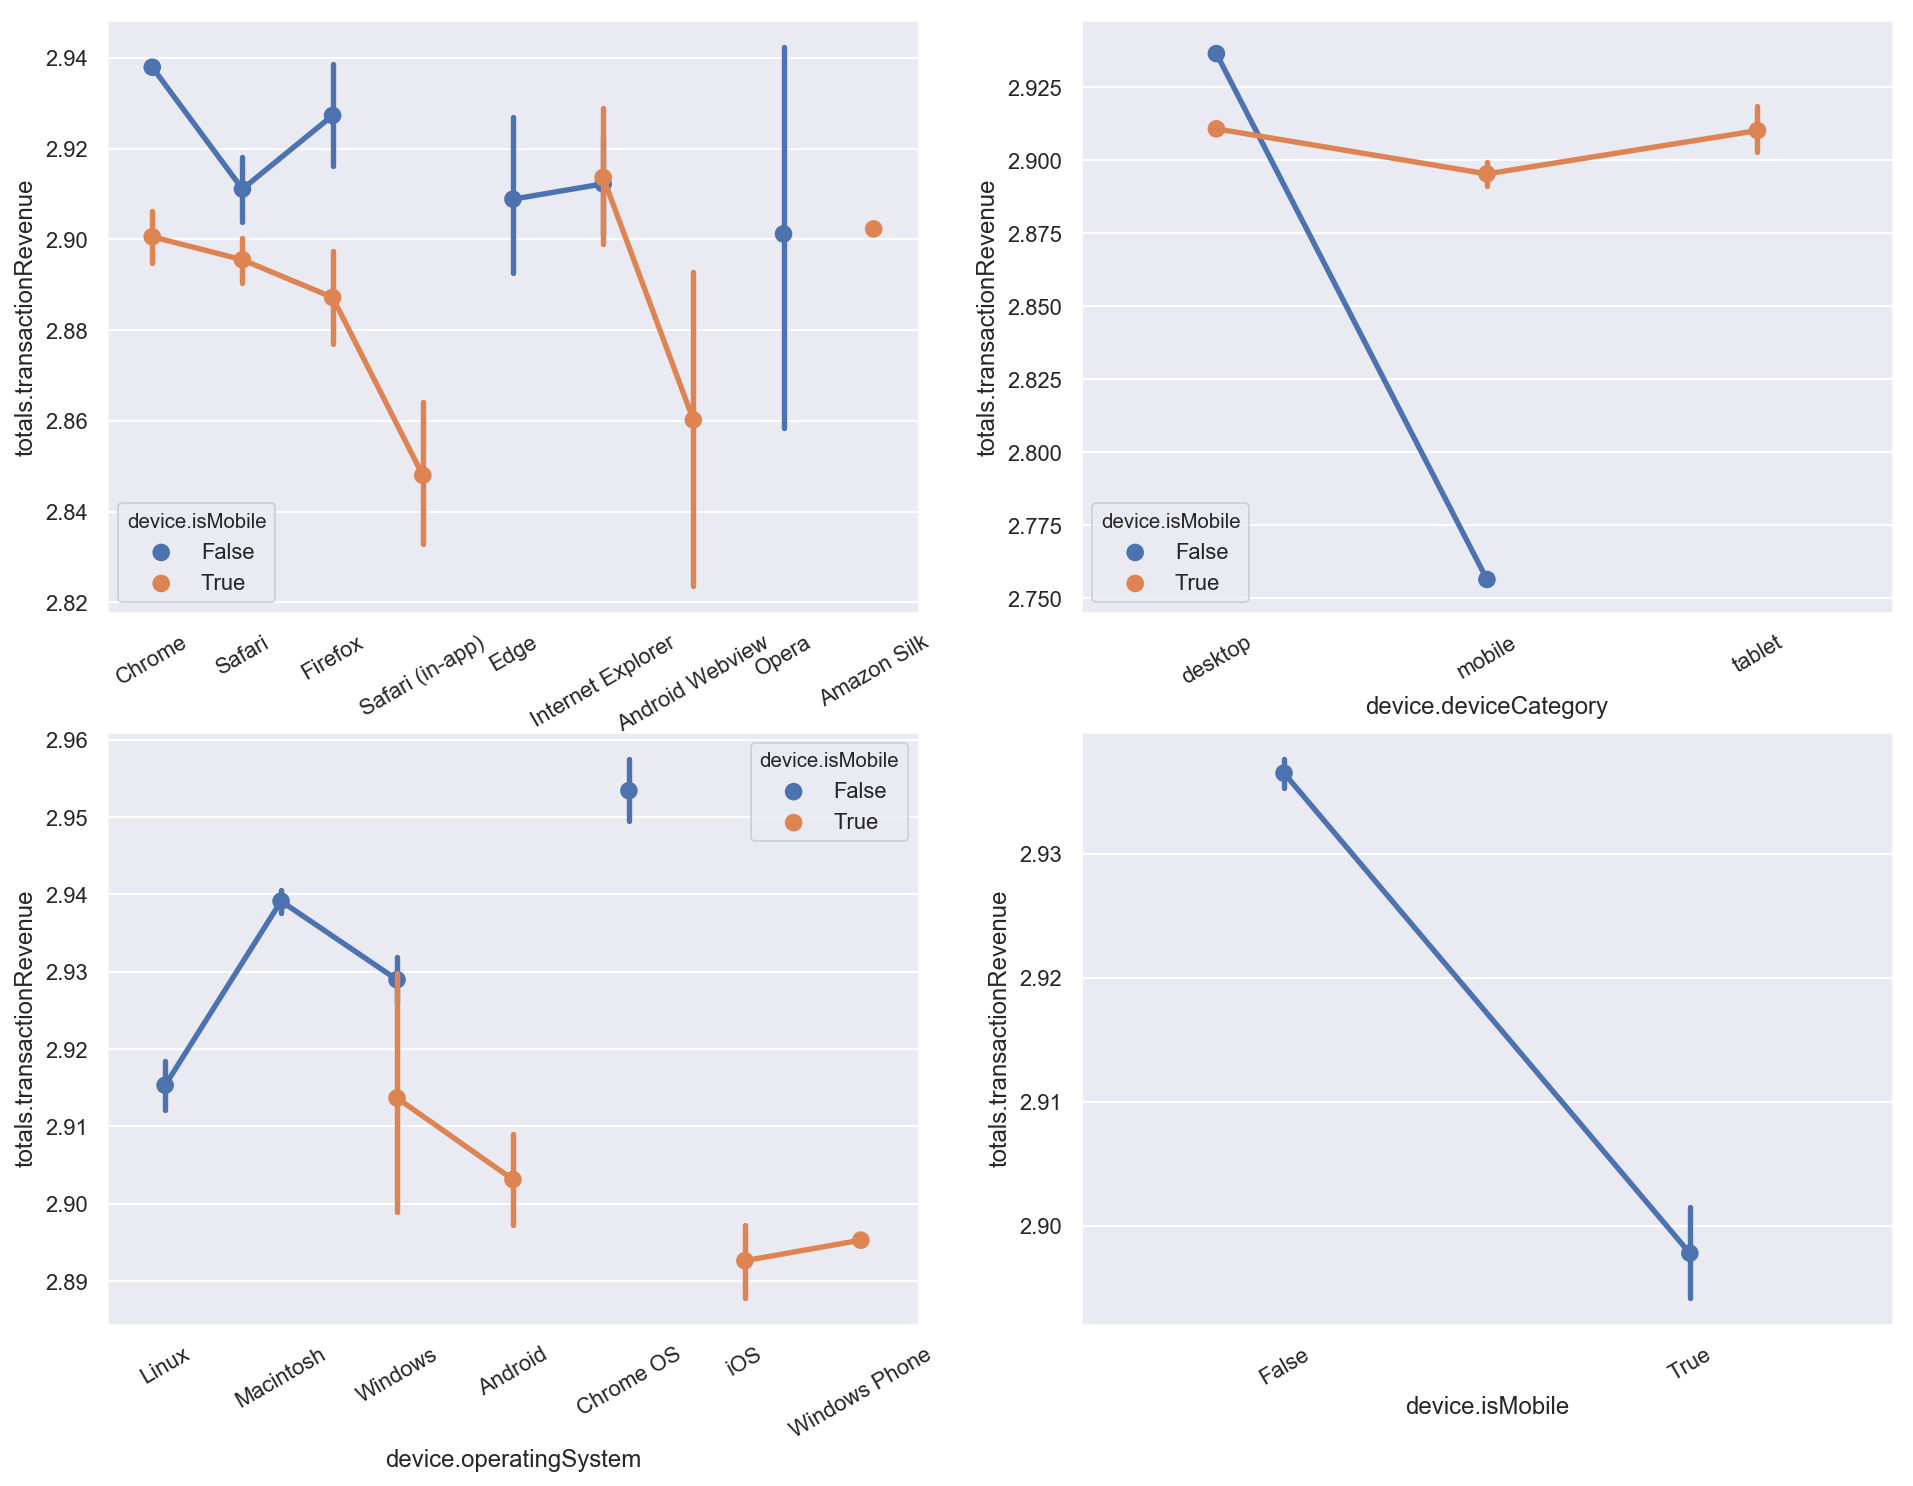

In [61]:
fig, ax = plt.subplots(2, 2, figsize = (16, 12))
print('Mean revenue per transaction')
sns.pointplot(x="device.browser", y="totals.transactionRevenue", hue="device.isMobile", data=train_, ax = ax[0, 0]);
sns.pointplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="device.isMobile", data=train_, ax = ax[0, 1]);
sns.pointplot(x="device.operatingSystem", y="totals.transactionRevenue", hue="device.isMobile", data=train_, ax = ax[1, 0]);
sns.pointplot(x="device.isMobile", y="totals.transactionRevenue", data=train_, ax = ax[1, 1]);
ax[0, 0].xaxis.set_tick_params(rotation=30);
ax[0, 1].xaxis.set_tick_params(rotation=30);
ax[1, 0].xaxis.set_tick_params(rotation=30);
ax[1, 1].xaxis.set_tick_params(rotation=30);

In [62]:
def show_count_sum(df, col):
    return df.groupby(col).agg({'totals.transactionRevenue': ['count', 'mean']}).sort_values(('totals.transactionRevenue', 'count'), ascending=False).head()
show_count_sum(train_, 'geoNetwork.subContinent')


totals.transactionRevenue          
                                            count      mean
geoNetwork.subContinent                                    
Northern America                            11143  2.932709
South America                                  98  2.960877
Eastern Asia                                   59  2.945818
Southeast Asia                                 32  2.956547
Western Europe                                 30  2.936443

In [63]:
show_count_sum(train_.loc[train_['geoNetwork.subContinent'] == 'Northern America'], 'geoNetwork.metro')


totals.transactionRevenue          
                                                      count      mean
geoNetwork.metro                                                     
not available in demo dataset                          4396  2.926095
San Francisco-Oakland-San Jose CA                      2912  2.931534
New York NY                                            1510  2.943810
Chicago IL                                              422  2.958546
Los Angeles CA                                          342  2.939002

In [64]:
show_count_sum(train_.loc[train_['geoNetwork.subContinent'] == 'Northern America'], 'geoNetwork.region')


totals.transactionRevenue          
                                                  count      mean
geoNetwork.region                                                
not available in demo dataset                      4396  2.926095
California                                         3297  2.932306
New York                                           1500  2.943710
Illinois                                            422  2.958546
Washington                                          335  2.930817

In [65]:
show_count_sum(train_, 'trafficSource.medium')


totals.transactionRevenue          
                                         count      mean
trafficSource.medium                                    
referral                                  5415  2.937768
organic                                   3438  2.919974
(none)                                    2042  2.943338
cpc                                        468  2.922265
cpm                                        142  2.961965

In [76]:
tmp = train["channelGrouping"].value_counts()
colors = ["#8d44fc", "#ed95d5", "#caadf7", "#6161b7", "#7e7eba", "#babad1"]
trace = go.Pie(labels=tmp.index, values=tmp.values, marker=dict(colors=colors))
layout = go.Layout(title="Channel Grouping", height=400)
fig = go.Figure(data = [trace], layout = layout)
py.iplot(fig, filename='basic_pie_chart')

In [81]:
# def getbin_hits(x):
#     if x < 5:
#         return "1-5"
#     elif x < 10:
#         return "5-10"
#     elif x < 30:
#         return "10-30"
#     elif x < 50:
#         return "30-50"
#     elif x < 100:
#         return "50-100"
#     else:
#         return "100+"
    
# agg_dict = {}
# for col in ["totals_bounces", "totals_hits", "totals_newVisits", "totals_pageviews", "totals_transactionRevenue"]:
#     train[col] = train[col].astype('float')
#     agg_dict[col] = "sum"
# tmp = train.groupby("fullVisitorId").agg(agg_dict).reset_index()
# tmp["total_hits_bin"] = tmp["totals_hits"].apply(getbin_hits)
# tmp["totals_bounces_bin"] = tmp["totals_bounces"].apply(lambda x : str(x) if x <= 5 else "5+")
# tmp["totals_pageviews_bin"] = tmp["totals_pageviews"].apply(lambda x : str(x) if x <= 50 else "50+")

# t1 = tmp["total_hits_bin"].value_counts()
# t2 = tmp["totals_bounces_bin"].value_counts()
# t3 = tmp["totals_newVisits"].value_counts()
# t4 = tmp["totals_pageviews_bin"].value_counts()

# fig = tools.make_subplots(rows=2, cols=2, subplot_titles=["Total Hits per User", "Total Bounces per User", 
#                                                          "Total NewVistits per User", "Total PageViews per User"], print_grid=False)

# tr1 = go.Bar(x = t1.index[:20], y = t1.values[:20])
# tr2 = go.Bar(x = t2.index[:20], y = t2.values[:20])
# tr3 = go.Bar(x = t3.index[:20], y = t3.values[:20])
# tr4 = go.Bar(x = t4.index, y = t4.values)

# fig.append_trace(tr1, 1, 1)
# fig.append_trace(tr2, 1, 2)
# fig.append_trace(tr3, 2, 1)
# fig.append_trace(tr4, 2, 2)

# fig['layout'].update(height=700, showlegend=False)
# py.iplot(fig)